In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from xgboost import XGBRegressor
# from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import r2_score
# from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, RandomOverSampler
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
from predict import Model



In [2]:
plt.rcParams['figure.figsize'] = [16, 16]

In [3]:
Model.models

{'linear': sklearn.linear_model._base.LinearRegression,
 'ridge': sklearn.linear_model._ridge.Ridge,
 'lasso': sklearn.linear_model._coordinate_descent.Lasso,
 'knn': sklearn.neighbors._regression.KNeighborsRegressor,
 'tree': sklearn.tree._classes.DecisionTreeRegressor,
 'forest': sklearn.ensemble._forest.RandomForestRegressor,
 'xgb': xgboost.sklearn.XGBRegressor,
 'neural': None}

In [4]:
m = Model('forest')
m.test_random_hyperparameters()

/Users/robotics/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 640 is smaller than n_iter=1000. Running 640 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [58]:
m = Model('linear')
m.train()
m.print_score()

--------------------------------------------------------------------------------
Scoring linear model.
Train score: 0.09909276595656946
Test score: -0.031774107719948264
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
Scoring forest model.
Train score: 0.13748691951047787
Test score: 0.04564877066877682
--------------------------------------------------------------------------------



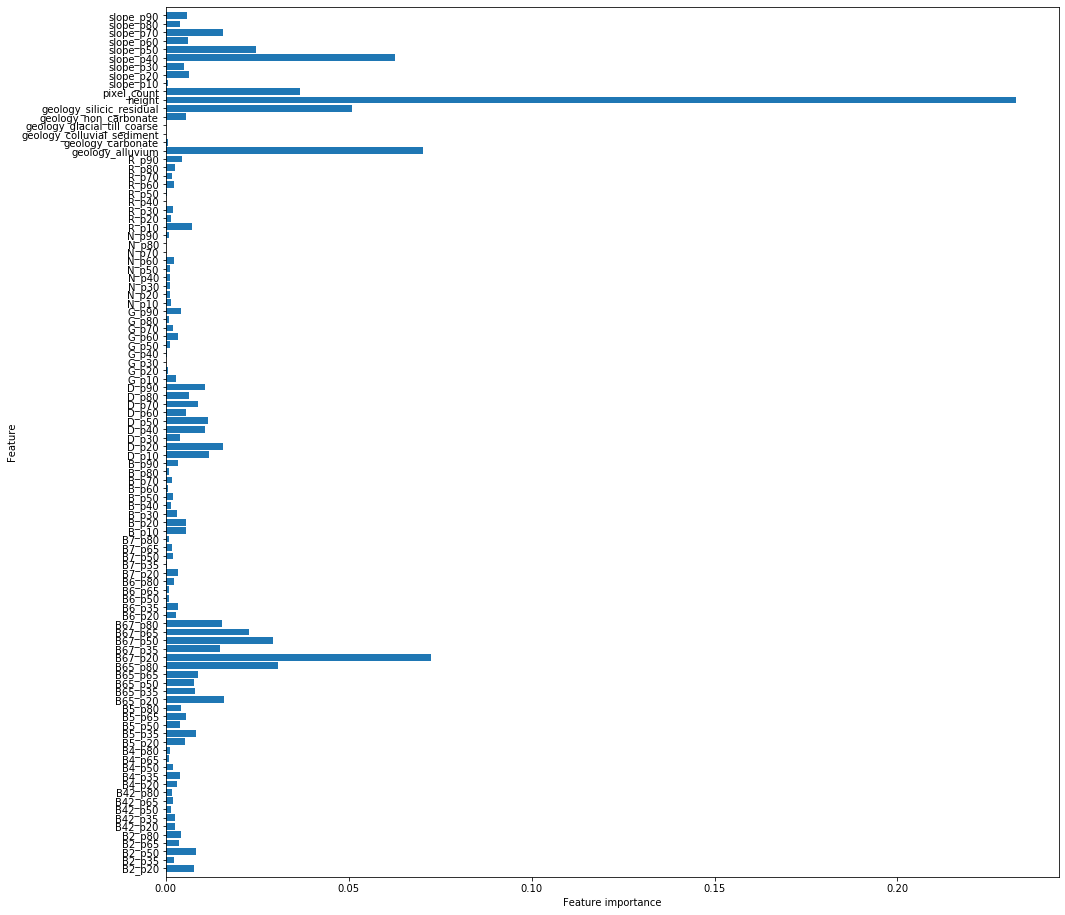

In [66]:
params = {'max_depth': 4, 'n_jobs': -1, 'n_estimators': 100}
m = Model('forest', params)
m.train()
m.print_score()
m.plot_feature_importance()

In [71]:
for key, m in Model.models.items():
    print(key)
    print(m.get_params())
    print('')

linear
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

ridge
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

lasso
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

knn
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

tree
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}

forest
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_dept

--------------------------------------------------------------------------------
Scoring xgb model.
Train score: 0.8856717610050472
Test score: 0.02581859216777005
--------------------------------------------------------------------------------



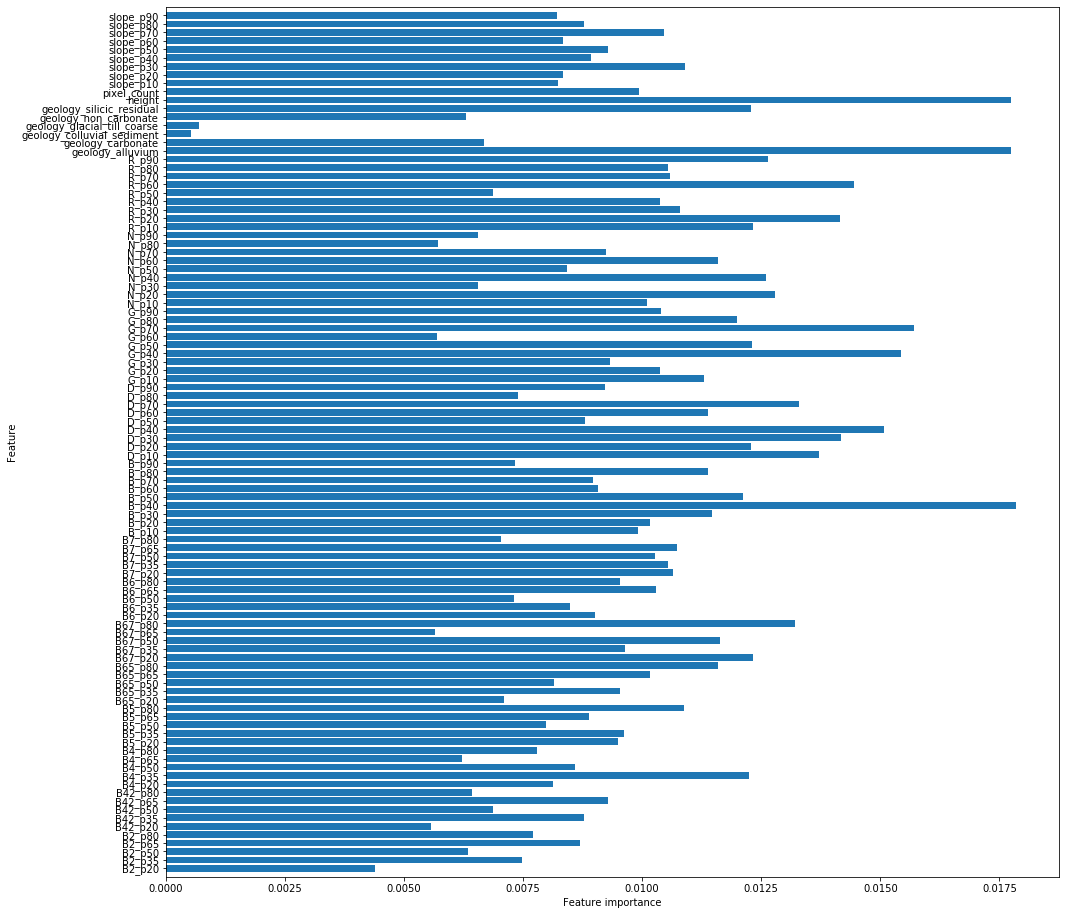

In [54]:
params = {'max_depth': 5, 'n_jobs': -1, 'n_estimators': 100, 'learning_rate': 0.1}
m = Model('xgb', params)
m.train()
m.print_score()
m.plot_feature_importance()

In [ ]:
  results = Model.data[['latitude', 'longitude', 'height', 'mp_score']].copy()
  results.height *= 1000
  for model_name in Model.models:
    parameters = {}
    if model_name in ['forest', 'xgb']:
      parameters = {'n_estimators': 200, 'n_jobs': -1}
    m = Model(model_name, parameters)
    m.train()
    m.print_score()
    results[model_name + '_score'] = m.get_predictions()
  results['summary_score'] = results.forest_score + results.xgb_score
  results.sort_values(by='summary_score', ascending=False, inplace=True)

In [282]:
def create_train_test(train_size=0.9):
    """Create balanced classes by oversampling."""
    
    # Discretizing the continuous target variable mp_score to create 10 integer classes
    X = accessible.drop(columns=['latitude', 'longitude', 'is_accessible', '.geo'])
    y = np.ceil(10 * accessible.mp_score).astype('int32')
    
    # Grabbing an equal number of samples from each class
    model = RandomOverSampler()
    X, y = model.fit_resample(X, y)
    
    # Going back to the continuous targets which we're kept in X. Using the
    # model indices to reset y.
    indices = model.sample_indices_
    y = X.mp_score[indices]
    X.drop('mp_score', axis=1, inplace=True)

    # Building the train test split.
    mask = np.random.rand(len(X)) < train_size
    X_train = X[mask]
    X_test = X[~mask]
    y_train = y[mask]
    y_test = y[~mask]
    return X_train, y_train, X_test, y_test

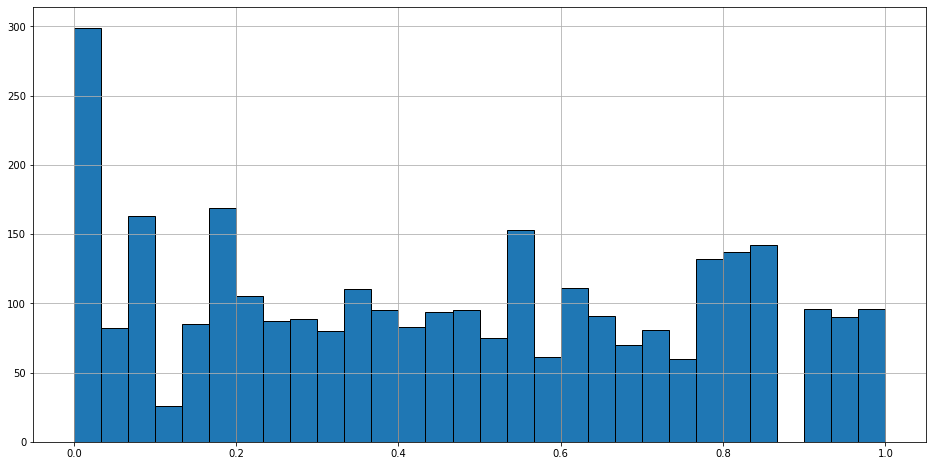

In [498]:
X_train, y_train, X_test, y_test = create_train_test()
y_train.hist(bins=30, edgecolor='black', linewidth=1.0);

In [509]:
def get_predictions(model, display=False, sort=False, X_train=None, y_train=None, X_test=None, y_test=None):
    """Print the inaccessible cliff formations with the highest predicted score."""
    
    results = df.drop(columns=['is_accessible', '.geo'])
    X_pred = results.drop(columns=['latitude', 'longitude', 'mp_score'])
    results[f'{model.name}_score'] = model.predict(X_pred)
    results.height *= 1000
    results = results[['latitude', 'longitude', 'height', 'mp_score', f'{model.name}_score']]
    if sort:
        results.sort_values(by=f'{model.name}_score', ascending=False, inplace=True)

    if display:
        print('\n' + '_' * 80 + '\n')
        print(f'Model: {model.name}')
        if X_train is None or y_train is None or X_test is None or y_test is None:
            print('Pass train and test data if you want to see model score.')
        else:
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            print(f'Train score: {r2_score(y_train, y_train_pred)}')
            print(f'Test score: {r2_score(y_test, y_test_pred)}')

        number_to_print = 20
        print(f'Top {number_to_print} results from {model.name} prediction.\n')
        print(results[:number_to_print].to_string(index=False))
        print('\n' + '_' * 80)

    return results

def run_linear(display=False, sort=False):
    """Train a simple linear regression."""
    X_train, y_train, X_test, y_test = create_train_test()
    model = LinearRegression()
    model.fit(X_train, y_train)
    model.name = 'linear'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)
    
def run_lasso(display=False, sort=False):
    """Train a lasso linear regression."""
    X_train, y_train, X_test, y_test = create_train_test()
    model = Lasso(alpha=0.001)
    model.fit(X_train, y_train)
    model.name = 'lasso'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)

def run_ridge(display=False, sort=False):
    """Train a lasso linear regression."""
    X_train, y_train, X_test, y_test = create_train_test()
    model = Ridge(alpha=100)
    model.fit(X_train, y_train)
    model.name = 'ridge'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)

def run_knn(k=40, display=False, sort=False):
    X_train, y_train, X_test, y_test = create_train_test()
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X_train, y_train)
    model.name = 'knn'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)

def run_xgb(n_estimators=100, display=False, sort=False):
    """Train a boosted gradient tree."""
    X_train, y_train, X_test, y_test = create_train_test()
    model = XGBRegressor(n_estimators=n_estimators, n_jobs=-1)
    model.fit(X_train, y_train)
    model.name = 'xgb'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)

def run_tree(display=False, sort=False):
    X_train, y_train, X_test, y_test = create_train_test()
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    model.name = 'tree'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)

def run_random_forest(n_estimators=100, display=False, sort=False):
    X_train, y_train, X_test, y_test = create_train_test()
    model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
    model.fit(X_train, y_train)
    model.name = 'random_forest'
    return get_predictions(model, display, sort, X_train, y_train, X_test, y_test)

def run_all():
    X = run_linear()
    X['lasso_score'] = run_lasso()['lasso_score']
    X['ridge_score'] = run_ridge()['ridge_score']
    X['xgb_score'] = run_xgb()['xgb_score']
    X['knn_score'] = run_knn()['knn_score']
    X['tree_score'] = run_tree()['tree_score']
    X['random_forest_score'] = run_random_forest()['random_forest_score']
    #X['sum_score'] = X['linear_score'] + 2 * X['xgb_score'] + X['knn_score']
    #X.sort_values(by='sum_score', ascending=False, inplace=True)
    return X


In [505]:
X = run_all()

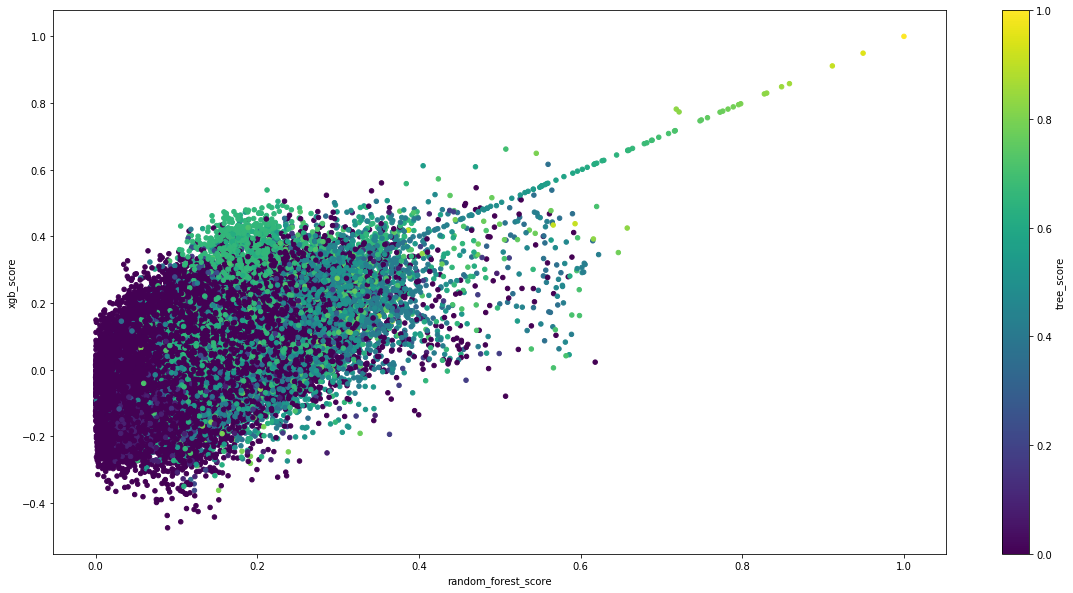

In [506]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
X.plot(x='random_forest_score', y='xgb_score', c='tree_score', kind='scatter', colormap='viridis', ax=ax)

plt.show()

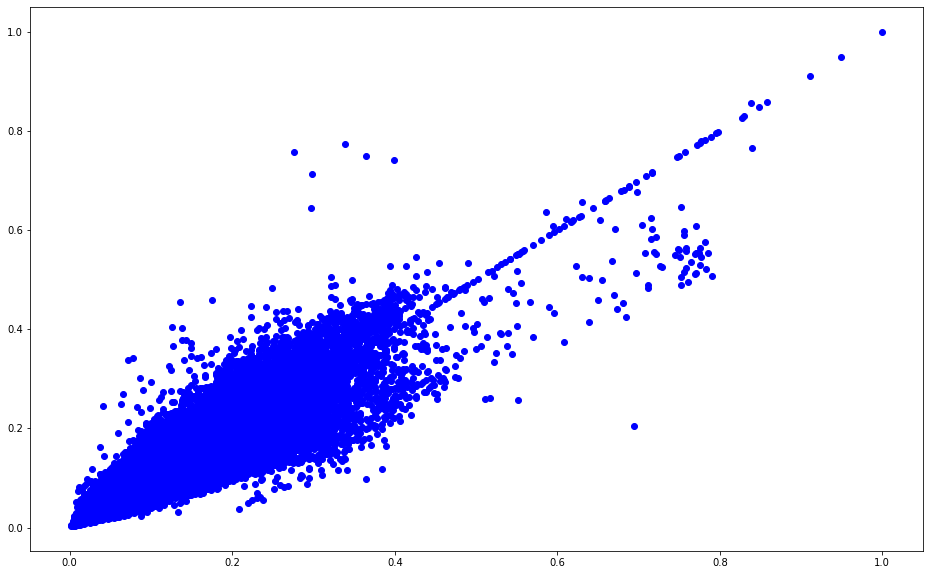

In [481]:
x1 = run_random_forest(1000)['random_forest_score']
x2 = run_random_forest(1000)['random_forest_score']
plt.plot(x1, x2, 'bo')

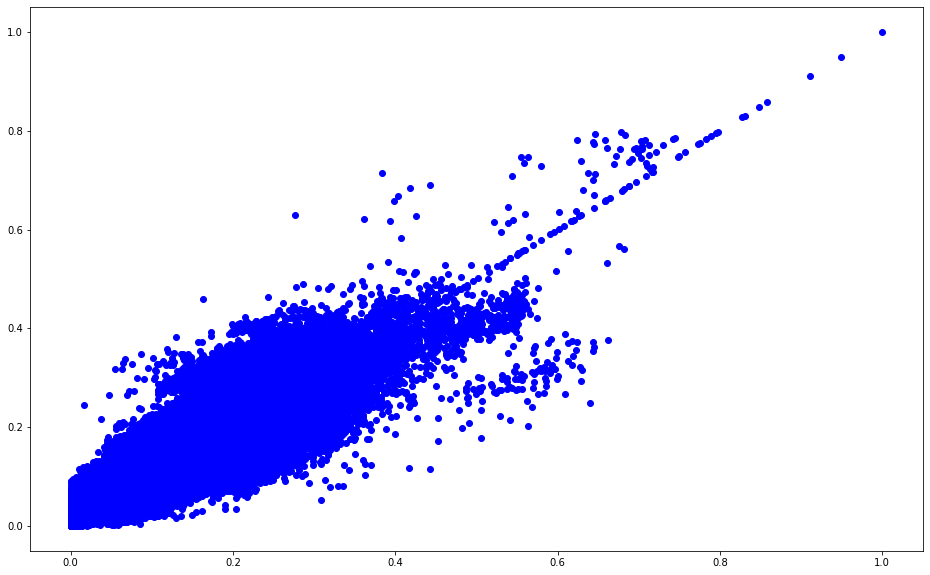

In [484]:
x1 = run_random_forest(100)['random_forest_score']
x2 = run_random_forest(100)['random_forest_score']
plt.plot(x1, x2, 'bo')

In [510]:
def plot_feature_importance(model, X_train):
    plt.barh(range(16), model.feature_importances_, align='center')
    plt.yticks(np.arange(16), X_train.columns)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.ylim(-1, 16)
    plt.show()

In [546]:
X_train, y_train, X_test, y_test = create_train_test()
model = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model.fit(X_train, y_train)
print(model.feature_importances_)
print(model.coeffs_)


print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

plot_feature_importance(model, X_train)

[1.04201368e-01 4.89171215e-02 6.59592498e-02 3.30070110e-02
 2.53953435e-02 1.06492855e-01 4.90392812e-02 3.07334866e-02
 6.01986136e-02 4.37563431e-03 7.50156043e-06 7.50682628e-03
 1.31519980e-02 1.95274625e-02 2.68157534e-01 1.63328713e-01]


AttributeError: 'RandomForestRegressor' object has no attribute 'coeffs_'

0.9999944220570599
0.9579492795864257


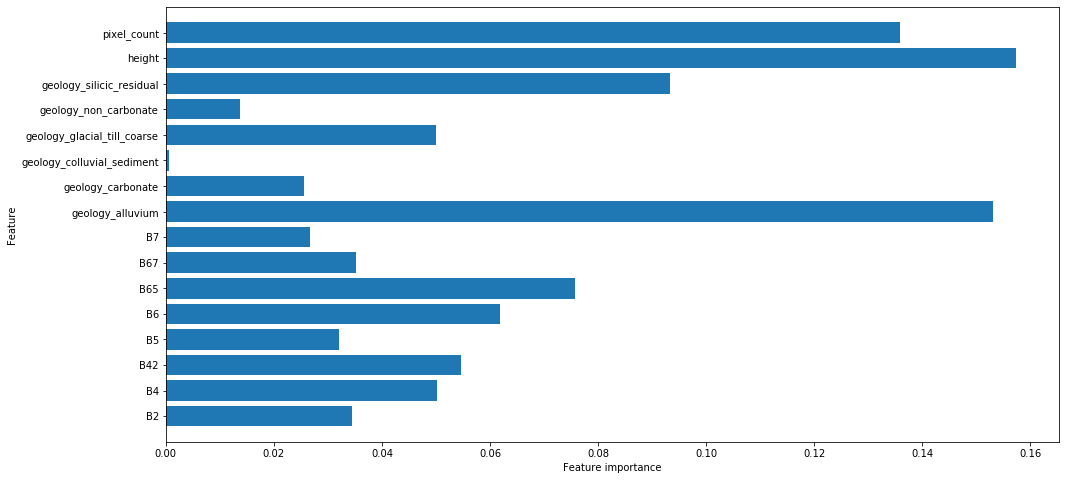

In [516]:
X_train, y_train, X_test, y_test = create_train_test()
model = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train, y_train)


print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

plot_feature_importance(model, X_train)


In [515]:
run_xgb(display=True, sort=True)


________________________________________________________________________________

Model: xgb
Train score: 0.9999353900765335
Test score: 0.9431885465861434
Top 20 results from xgb prediction.

  latitude   longitude  height  mp_score  xgb_score
 37.731722 -119.635903   884.0  1.000000   0.999836
 36.035968 -115.468416   329.0  0.949453   0.949416
 40.257100 -105.614314   447.0  0.911422   0.911430
 38.584093 -107.710476   433.0  0.858352   0.857925
 37.742642 -119.533536   424.0  0.848630   0.848601
 38.121889 -119.414868   307.0  0.830230   0.829941
 36.111683 -115.489437   334.0  0.827322   0.827209
 36.066924 -113.801141   535.0  0.000000   0.823802
 36.012695 -113.729622   370.0  0.000000   0.816769
 40.280991 -105.673060   345.0  0.798070   0.797424
 37.450823 -113.162111   239.0  0.795383   0.794732
 37.717639 -119.637921   622.0  0.788869   0.788329
 37.745417 -119.535080   616.0  0.782359   0.781731
 37.748086 -119.560296   380.0  0.775895   0.775495
 48.515742 -120.656968   2

,latitude,longitude,height,mp_score,xgb_score
48235,37.731722,-119.635903,884.0,1.000000,0.999836
22404,36.035968,-115.468416,329.0,0.949453,0.949416
54240,40.257100,-105.614314,447.0,0.911422,0.911430
59523,38.584093,-107.710476,433.0,0.858352,0.857925
50367,37.742642,-119.533536,424.0,0.848630,0.848601
...,...,...,...,...,...
36709,44.182349,-110.906730,60.0,0.000000,-0.598402
56357,40.737777,-110.821185,68.0,0.000000,-0.599645
63177,40.938018,-110.223406,72.0,0.000000,-0.608766
55552,39.984906,-107.307395,55.0,0.000000,-0.615950


In [423]:
a, b = **d

SyntaxError: invalid syntax (<ipython-input-423-eee33dfd1884>, line 1)

In [430]:
def f(**kwargs):
    x = kwargs['x']
    return 2 * x

f(x=3)

6

In [563]:
d = {'alpha': 5}
g = XGBRegressor()
g.set_params(**d)

XGBRegressor(alpha=5, base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)

In [5]:
from sklearn.neighbors import KNeighborsRegressor

In [6]:
dir(Model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'accessible',
 'best_params',
 'data',
 'get_predictions',
 'models',
 'plot_feature_importance',
 'print_evaluate_hyperparameters',
 'print_score',
 'set_train_test',
 'test_random_hyperparameters',
 'train',
 'tune_all_hyperparameters']